Available cases:
  [0] case001_20251225-132520
  [1] case002_20251225-132656
  [2] case003_20251225-132854
Case 'case001_20251225-132520' has 41 files (field-xxxxx.dat)
Plotting file: data/case001_20251225-132520/field-00040.dat
 t =  3.9996447252022795
 size = ( 402  x  402 )


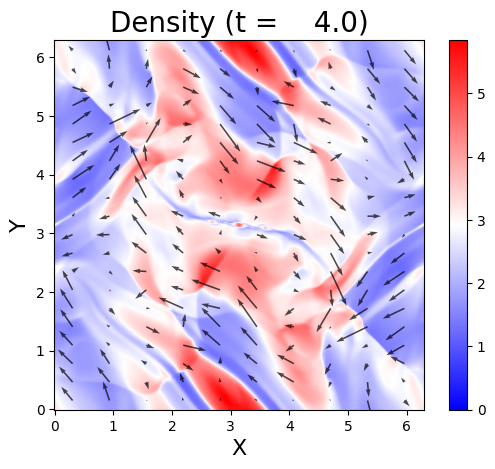

In [5]:
%matplotlib inline
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import openmhd

# dummy index
vx=0;vy=1;vz=2;pr=3;ro=4;bx=5;by=6;bz=7;ps=8

base_dir = Path('./data')
case_dirs = sorted([p for p in base_dir.iterdir() if p.is_dir()])
if not case_dirs:
    raise RuntimeError(f'No case directories found in {base_dir}')
print('Available cases:')
for idx, c in enumerate(case_dirs):
    print(f'  [{idx}] {c.name}')

case_index = 0  # <-- change this to choose a case
case_dir = case_dirs[case_index]
field_files = sorted(case_dir.glob('field-?????.dat'))
if not field_files:
    raise RuntimeError(f'No field files found in {case_dir}')
print(f"Case '{case_dir.name}' has {len(field_files)} files (field-xxxxx.dat)")

field_index = max(0, len(field_files)-1)  # <-- change this to choose a field number
input_data_file = str(field_files[field_index])
print(f'Plotting file: {input_data_file}')

# reading the data ...
x,y,t,data = openmhd.data_read(input_data_file)
# reading the data (partial domain: [ix1,ix2] x [jx1,jx2])
# x,y,t,data = openmhd.data_read(input_data_file,ix2=101,jx1=50,jx2=101)

# clearing the current figure, if any
plt.clf()
# extent: [left, right, bottom, top]
extent=[x[0],x[-1],y[0],y[-1]]
# 2D plot (vmin/mymin: minimum value, vmax/mymax: max value)
# Note: ().T is necessary for 2-D plot routines (imshow/pcolormesh...)
tmp = np.ndarray((x.size,y.size),np.double)
tmp[:,:] = data[:,:,ro]
mymax = max(tmp.max(), -tmp.min()) if( tmp.max() > 0.0 ) else 0.0
mymin = min(tmp.min(), -tmp.max()) if( tmp.min() < 0.0 ) else 0.0
myimg = plt.imshow(tmp.T,origin='lower',vmin=mymin,vmax=mymax,cmap='bwr',extent=extent)

# image operations (e.g. colormaps)
# myimg.set_cmap('jet')
# myimg.set_cmap('RdBu_r')  # colortable(70,/reverse) in IDL
# myimg.set_cmap('seismic')
# myimg.set_cmap('bwr')
# myimg.set_cmap('gnuplot2')

# useful options
# plt.grid()
plt.xlabel('X',size=16)
plt.ylabel('Y',size=16)
plt.title(f'Density (t = {t:6.1f})', size=20)

# color bar (next to myimg)
plt.colorbar()

# flow vectors
# Note: ().T is necessary for a 2-D array
myxsub = 40; myysub = 20; myxsub0 = int(myxsub/2); myysub0 = int(myysub/2)
myvec = plt.quiver( x[myxsub0::myxsub],
                    y[myysub0::myysub],
                    data[myxsub0::myxsub,myysub0::myysub,vx].T,
                    data[myxsub0::myxsub,myysub0::myysub,vy].T,
                    alpha=0.7,angles='xy')

# plot
plt.show()

# image file
# plt.savefig('output.png', dpi=144)


In [6]:
# %matplotlib inline  # 使わない

import time
import traceback
import threading
from pathlib import Path
from io import BytesIO

import numpy as np

import matplotlib
matplotlib.use("Agg")          # pyplot より前
import matplotlib.pyplot as plt
plt.ioff()

import openmhd
import ipywidgets as widgets
from IPython.display import display, clear_output

# dummy index
vx=0;vy=1;vz=2;pr=3;ro=4;bx=5;by=6;bz=7;ps=8

labels = {
    'Vx':0,'Vy':1,'Vz':2,'Pressure':3,'Density':4,
    'Bx':5,'By':6,'Bz':7,'Psi':8
}
cmaps = ['jet','RdBu_r','bwr','seismic','gnuplot2']

# -----------------------------
# UI widgets
# -----------------------------
base_dir = Path('data')
case_dirs = sorted([p for p in base_dir.iterdir() if p.is_dir()])
if not case_dirs:
    raise RuntimeError(f'No case directories under {base_dir}')

case_dropdown = widgets.Dropdown(
    options=[(p.name, str(p)) for p in case_dirs],
    description='Case:',
    layout=widgets.Layout(width='50%')
)
field_dropdown = widgets.Dropdown(description='Field:', layout=widgets.Layout(width='50%'))

label_options = [(name, idx) for name, idx in labels.items()]
label_dropdown = widgets.Dropdown(options=label_options, value=label_options[0][1], description='Quantity:')
cmap_dropdown = widgets.Dropdown(options=cmaps, value='jet', description='Colormap:')

plot_button = widgets.Button(description='Plot', button_style='primary')

# 表示は「上書き」ウィジェットのみ（Outputは使わない）
img_widget = widgets.Image(format='png')
status_html = widgets.HTML(value="Ready.")
log_area = widgets.Textarea(
    value="",
    description="Log:",
    layout=widgets.Layout(width='100%', height='260px'),
    disabled=True
)

controls = widgets.VBox([
    widgets.HBox([case_dropdown, field_dropdown]),
    widgets.HBox([label_dropdown, cmap_dropdown]),
    plot_button
])

# -----------------------------
# State
# -----------------------------
_call_count = 0
_last_call_ts = None

# 多重クリックは一応ガード（ただし今回の本丸は Output 排除）
_click_lock = threading.Lock()
_in_flight = False
_last_accept_ts = 0.0
DEBOUNCE_SEC = 0.7

# ログは Python 側で状態として保持し、Textarea.value を上書き
_log_lines = []

def _append_log(line: str):
    _log_lines.append(line)
    # 表示は「全体を上書き」：重複描画が来ても最終状態は同じ
    log_area.value = "\n".join(_log_lines[-400:])  # 過去400行程度に制限

def _set_status(msg: str):
    status_html.value = f"<pre style='margin:0'>{msg}</pre>"

# -----------------------------
# Field refresh
# -----------------------------
def refresh_fields(*args):
    case_path = Path(case_dropdown.value)
    fields = sorted(case_path.glob('field-?????.dat'))

    if not fields:
        field_dropdown.options = []
        field_dropdown.value = None
        field_dropdown.disabled = True
        return

    # options は (表示名, 値) で統一
    opts = [(f.name, str(f)) for f in fields]
    field_dropdown.options = opts
    field_dropdown.disabled = False

    # value は必ず options 内の値に揃える（古い value を残さない）
    first_val = opts[0][1]
    if field_dropdown.value not in [v for _, v in opts]:
        field_dropdown.value = first_val
    else:
        # 既に有効ならそのまま
        pass


case_dropdown.observe(refresh_fields, names='value')
refresh_fields()

# -----------------------------
# Plot handler
# -----------------------------
def handle_plot(_btn):
    global _call_count, _last_call_ts
    global _in_flight, _last_accept_ts

    now = time.time()

    # guard（多重実行対策：保険）
    with _click_lock:
        if _in_flight:
            _append_log("[DROP] in_flight=True")
            return
        if (now - _last_accept_ts) < DEBOUNCE_SEC:
            _append_log(f"[DROP] debounce dt={now - _last_accept_ts:.3f}s < {DEBOUNCE_SEC}s")
            return
        _in_flight = True
        _last_accept_ts = now

    plot_button.disabled = True
    _set_status("Plotting...")

    try:
        _call_count += 1
        dt_prev = None if _last_call_ts is None else (now - _last_call_ts)
        _last_call_ts = now

        _append_log("=" * 80)
        _append_log(f"[ACCEPT CALL #{_call_count}] {time.strftime('%Y-%m-%d %H:%M:%S')}  dt_from_prev={dt_prev}")
        _append_log(f"  click_handlers={len(getattr(plot_button._click_handlers, 'callbacks', []))}")
        _append_log(f"  case={case_dropdown.value}")
        _append_log(f"  field={field_dropdown.value}")
        _append_log(f"  quantity={label_dropdown.label} idx={label_dropdown.value}")
        _append_log(f"  cmap={cmap_dropdown.value}")

        if not field_dropdown.value:
            _set_status("No field files for selected case.")
            _append_log("  -> aborted: no field file selected")
            return

        t0 = time.time()
            # field_dropdown.value が壊れている/古い可能性があるので options から確定する
        current_opts = list(field_dropdown.options)
        if not current_opts:
            _set_status("No field files for selected case.")
            return

        # Dropdown の options は (label, value) か value 単体の場合があるので両対応
        def _opt_value(opt):
            return opt[1] if isinstance(opt, (tuple, list)) and len(opt) == 2 else opt

        valid_values = [_opt_value(o) for o in current_opts]
        if field_dropdown.value in valid_values:
            inputdata = field_dropdown.value
        else:
            inputdata = valid_values[0]
            field_dropdown.value = inputdata  # UI も同期

        label_name = label_dropdown.label
        mylabel = label_dropdown.value
        mycmap = cmap_dropdown.value

        x, y, t, data = openmhd.data_read(inputdata)
        extent = [x[0], x[-1], y[0], y[-1]]

        tmp = np.asarray(data[:, :, mylabel], dtype=np.double)

        mymax = max(tmp.max(), -tmp.min()) if tmp.max() > 0.0 else 0.0
        mymin = min(tmp.min(), -tmp.max()) if tmp.min() < 0.0 else 0.0

        fig, ax = plt.subplots(figsize=(8, 6))
        im = ax.imshow(tmp.T, origin='lower', vmin=mymin, vmax=mymax, cmap=mycmap, extent=extent)
        ax.set_xlabel('X', size=16)
        ax.set_ylabel('Y', size=16)
        ax.set_title(f'{label_name} (t = {t:6.1f})', size=20)
        fig.colorbar(im, ax=ax)

        myxsub = 40; myysub = 20
        myxsub0 = int(myxsub / 2); myysub0 = int(myysub / 2)
        ax.quiver(
            x[myxsub0::myxsub],
            y[myysub0::myysub],
            data[myxsub0::myxsub, myysub0::myysub, vx].T,
            data[myxsub0::myxsub, myysub0::myysub, vy].T,
            alpha=0.7, angles='xy'
        )

        buffer = BytesIO()
        fig.savefig(buffer, format='png', bbox_inches='tight')
        plt.close(fig)
        png_bytes = buffer.getvalue()

        # 画像は 1 枚を上書き更新
        img_widget.value = png_bytes

        dt = time.time() - t0
        _set_status(f"Plotted: {label_name}  t={t:6.1f}  (CALL #{_call_count}, {dt:.3f}s)")
        _append_log(f"  -> rendered ok: bytes={len(png_bytes)} elapsed={dt:.3f}s")

    except Exception as e:
        _set_status("Error while plotting. See log.")
        _append_log(f"  -> ERROR: {repr(e)}")
        _append_log(traceback.format_exc())

    finally:
        plot_button.disabled = False
        with _click_lock:
            _in_flight = False

# ハンドラを 1 個に固定
try:
    plot_button._click_handlers.callbacks.clear()
except Exception:
    pass
plot_button.on_click(handle_plot)

# -----------------------------
# Render UI
# -----------------------------
ui = widgets.VBox([
    controls,
    widgets.HTML("<b>Status</b>"),
    status_html,
    widgets.HTML("<b>Plot</b>"),
    img_widget,
    log_area
])

clear_output(wait=True)
display(ui)
